<a href="https://colab.research.google.com/github/ToddMG/DS-Unit-2-Regression-Classification/blob/master/module3/TG_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 133kB 16.6MB/s 
     |████████████████████████████████| 7.1MB 35.9MB/s 
     |████████████████████████████████| 614kB 44.1MB/s 
     |████████████████████████████████| 225kB 39.0MB/s 
     |████████████████████████████████| 768kB 40.5MB/s 
     |████████████████████████████████| 194kB 29.2MB/s 
     |████████████████████████████████| 51kB 20.6MB/s 
     |████████████████████████████████| 51kB 19.4MB/s 
     |████████████████████████████████| 737kB 41.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=86aa80636e2dc68d394ea6461fd463c5c4cdc4d862abd8a210738743a8d65044
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=fa86fc1deee91e0580753adc073c518e9d5c558671405908fe03ed3f24e29db4
  Stored

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Dependencies
import pandas as pd
import pandas_profiling
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
import category_encoders as ce

In [0]:
# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

##Exploring Data

In [35]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


##Filtering data

In [0]:
# Only include 01 ONE FAMILY DWELLINGS rows
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

In [37]:
print(df.shape)
df.head()

(5061, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
42,3,MADISON,01 ONE FAMILY DWELLINGS,1,6809,54,NaN,A1,2601 AVENUE R,NaN,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,01/01/2019
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [38]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# Only include homes sold for over 100,000 and under 2 million.
df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]

In [40]:
df.SALE_PRICE.min()

100000

In [41]:
df.SALE_PRICE.max()

2000000

In [0]:
# Fix SALE_DATE and transform to datetime format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True);

In [52]:
df.SALE_DATE.dtype

dtype('<M8[ns]')

##Split Train/Test data sets

In [0]:
df = df.set_index('SALE_DATE')
train = df['2019-01':'2019-03'].reset_index()
test = df['2019-04':'2019-04'].reset_index()
df = df.reset_index()

In [71]:
train.shape

(2517, 21)

In [72]:
test.shape

(647, 21)

##Explore data and features using Seaborn

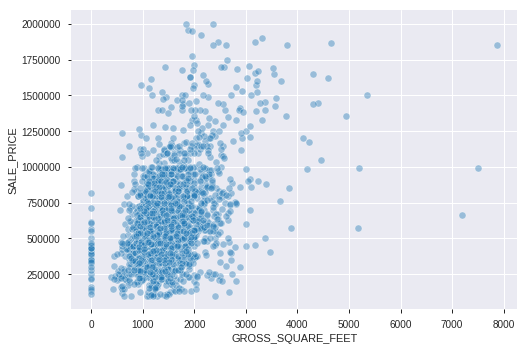

In [78]:
sns.scatterplot(data=train, x="GROSS_SQUARE_FEET", y="SALE_PRICE", alpha=0.4)

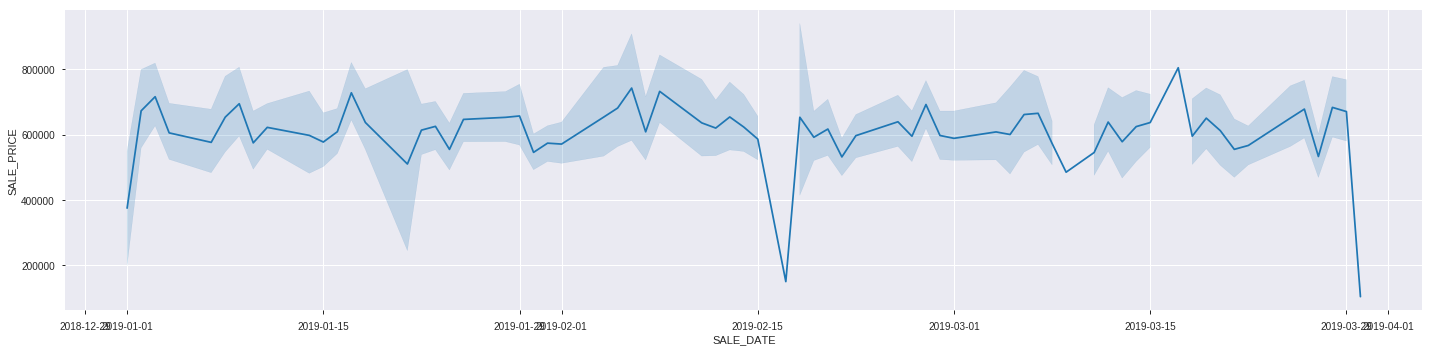

In [84]:
sns.relplot(data=train, x='SALE_DATE', y='SALE_PRICE', kind='line', aspect=4)

##One-hot Encoding

In [86]:
# Check categorical features for amount of unique values
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaN,NaN
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2517,178,FLUSHING-NORTH,78,NaN,NaN
LAND_SQUARE_FEET,2517,889,"4,000",235,NaN,NaN
ADDRESS,2517,2507,216-29 114TH ROAD,2,NaN,NaN


In [0]:
# Change LAND_SQUARE_FEET to float value
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',', '')
train['LAND_SQUARE_FEET'] = train.LAND_SQUARE_FEET.astype(float)

test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',', '')
test['LAND_SQUARE_FEET'] = test.LAND_SQUARE_FEET.astype(float)

In [93]:
test.head()

,SALE_DATE,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
0,2019-04-01,2,RIVERDALE,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,5000.0,2272.0,1930.0,1,A1,895000
1,2019-04-01,2,THROGS NECK,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,2500.0,720.0,1935.0,1,A2,253500
2,2019-04-01,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,2880.0,2210.0,1925.0,1,A1,1300000
3,2019-04-01,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,1247 EAST 40TH STREET,NaN,11210.0,1.0,0.0,1.0,1305.0,1520.0,1915.0,1,A5,789000
4,2019-04-01,3,GERRITSEN BEACH,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,2314 PLUMB 2ND STREET,NaN,11229.0,1.0,0.0,1.0,1800.0,840.0,1925.0,1,A9,525000


In [88]:
# Make sure it worked
train.TAX_CLASS_AT_PRESENT.value_counts()

1     2486
1D      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [109]:
# Another check
test.TAX_CLASS_AT_PRESENT.value_counts()

1     637
1D     10
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [0]:
# One hot encoding for TAX_CLASS_AT_PRESENT (the only categorical feature with a reasonable amount of unique variables.)
encoder = ce.OneHotEncoder(use_cat_names=True, cols='TAX_CLASS_AT_PRESENT')
train_enc = encoder.fit_transform(train)
test_enc = encoder.transform(test)

In [0]:
# Clean up categorical features we won't be using
train_enc_subset = train_enc.select_dtypes('number').dropna(axis='columns')
test_enc_subset = test_enc.select_dtypes('number').dropna(axis='columns')

In [0]:
# Split into target and features
target = 'SALE_PRICE'
features = train_enc_subset.columns.drop(target)

X_train_enc = train_enc_subset[features]
X_test_enc = test_enc_subset[features]
y_train_enc = train_enc_subset[target]
y_test_enc = test_enc_subset[target]

In [119]:
# Display remaining features
X_train_enc.columns

Index(['BOROUGH', 'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK',
       'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

##SelectKBest

In [0]:
from sklearn.feature_selection import SelectKBest, f_regression

In [120]:
#1. Import appropiate class
#2. Instantiate the class
#3. Call the fit method

selector = SelectKBest(score_func=f_regression, k=8)

# fit_transform on train set
# transform on test set

X_train_selected = selector.fit_transform(X_train_enc, y_train_enc)
X_test_selected = selector.transform(X_test_enc)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [121]:
X_train_selected.shape, X_test_selected.shape

((2517, 8), (647, 8))

##Fit Linear Regression model and check for Test set MAE.

In [122]:
model = LinearRegression()
model.fit(X_train_selected, y_train_enc)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test_enc, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $162,904
